In [1756]:
import sys
sys.version_info
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time
import random

In [1757]:
pd.set_option('display.max_columns', None)

## First: load in our data and do some basic analysis to look for problems

In [1758]:
#read in the data
marathon_data = pd.read_csv("data.csv")
marathon_data = marathon_data.dropna()
marathon_data['Time'] = pd.to_timedelta(marathon_data['Time'])
marathon_data.head()

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
0,1,carlos enrique portugal quintero,30,M,1263,04:15:00,09:44,2016
1,2,leonel furlan,60,M,2289,05:05:42,11:41,2016
2,3,meredith gray,30,F,2276,05:04:34,11:38,2016
3,4,jason ainspan,35,M,670,03:52:57,08:53,2015
4,4,jason ainspan,35,M,2390,05:13:30,11:58,2016


In [1759]:
marathon_data.groupby("Id").size().sort_values(ascending = False).head(2)
#Clearly we have a problem with this ID
#marathon_data[marathon_data["Id"] == 3327]

Id
3327    347
1640     13
dtype: int64

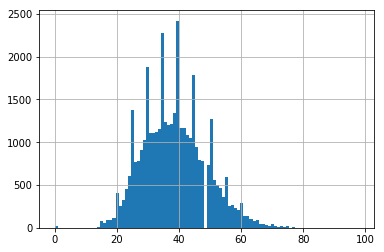

In [1760]:
marathon_data["Age Category"].hist(bins = 100)

In [1761]:
for yr in marathon_data.groupby('Year').groups: 
    print(yr, str(marathon_data.groupby('Year').get_group(yr)['Time'].mean()))
#here, we are trying to figure out which year was the half marathon (2013)
#Let's drop that year
marathon_data = marathon_data[marathon_data.Year != 2013]
#marathon_data.Year.value_counts()

2016 0 days 04:32:55.103116
2003 0 days 04:18:00.990378
2004 0 days 04:28:34.934463
2005 0 days 04:25:55.415105
2006 0 days 04:37:25.943564
2007 0 days 04:43:34.228222
2008 0 days 04:28:04.394986
2009 0 days 04:29:01.636166
2010 0 days 04:36:43.382291
2011 0 days 04:27:12.712468
2012 0 days 04:35:52.052658
2013 0 days 01:51:27.648069
2014 0 days 04:43:50.870375
2015 0 days 04:30:48.480377


In [1762]:
##Do we want to remove the entries without valid name?

#marathon_data.Name.value_counts().sort_values().tail()
#Note: we see that some of the participants have the name set to private. we should probably drop these 
#marathon_data = marathon_data[marathon_data.Name != "private"]
#marathon_data.Name.value_counts().sort_values().tail()
#marathon_data = marathon_data[marathon_data.Name.str.contains("#") == False]
#get rid of one garbage name

In [1763]:
marathon_data.sort_values('Time').head()
#This looks good (all the very low times are winners of the race, or close to it)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
5268,3243,david ruto,23,M,1,02:12:22,05:03,2003
7631,4390,otavio dos santos p,29,M,2,02:12:23,05:03,2003
6621,3816,kiplimo rono,32,M,3,02:12:40,05:03,2003
24807,17531,tesfaye alemayehu,25,M,1,02:12:57,05:04,2011
8341,4853,william gomez amori,25,M,1,02:14:42,05:08,2004


In [1764]:
marathon_data.groupby('Name').size().sort_values(ascending = False).head(2)
#This is reasonable, we se that some people participated in the marathon each year that it occured

Name
private          301
alexis garcia     13
dtype: int64

In [1765]:
data_pivot[data_pivot.index == 3327]

Rank                                                                   \
Year 2003  2004  2005  2006  2007  2008  2009 2010  2011  2012  2013  2014   
Id                                                                           
3327  249  1625  1725  1859  1733  1101  1601  374  2611  2041  2269  1682   

                Age Category                                               \
Year 2015  2016         2003 2004 2005 2006 2007 2008 2009 2010 2011 2012   
Id                                                                          
3327  810  None           42   22   44   40   39   25   31   45   52   50   

                                      Time                                    \
Year 2013 2014 2015  2016             2003             2004             2005   
Id                                                                             
3327   39   22   40  None  0 days 03:36:20  0 days 05:40:28  0 days 06:34:57   

                                                                          \
Year             2006             2007             2008             2009   
Id                                                                         
3327  0 days 05:14:07  0 days 05:02:28  0 days 04:14:41  0 days 04:35:10   

                                                                          \
Year             2010             2011             2012             2013   
Id                                                                         
3327  0 days 03:43:45  0 days 04:56:47  0 days 04:34:12  0 days 01:56:07   

                                              
Year             2014             2015  2016  
Id                                            
3327  0 days 04:37:06  0 days 03:58:38  None

## Now, we have clean data but need to extract the features for our models

In [1766]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")


def create_frame(last_year):
    start = time.time()
    
    #This is the function to create a frame with the relavant features for each runner, given a year
    #The basic process is we create a pandas pivot table to help us, then we iterate over this pivot table (mostly using apply)
    #to create a new pandas dataframe (new_frame) that contains all relavent features 
    
    #the year we input (last_year) is the last year that we look at (1 year back from current)
    #IE, if we are looking to predict for 2017, we would give 2016 as the last_year, and the features would include all years up to 2016
    
    new_frame = pd.DataFrame(data = {"Id": marathon_data.Id, "Sex": marathon_data.Sex})
    new_frame = working_frame.drop_duplicates("Id")
    new_frame["Sex"] = pd.get_dummies(working_frame["Sex"])
    #1 is male, 0 is female
    
    new_frame.index = new_frame.Id
    
    #helper functions
    def lastfilled(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key-1
            if (key == 2013):
                key = key - 1
            if (key < 2003): 
                return None 
        return (last_year - key + 1)
        
    def valuelast(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key - 1
            if (key == 2013):
                key = key - 1
            if (key < 2003): 
                return None
        return row.loc[key]
    
    
    for i in range(0,(last_year - 2003)):
        #Here we iterate over the relavent columns in order to get the dummies for participation
        #Each column will be a boolean variable, with a 0 if the runner participated that year, and a 0 otherwise
        #the output is expressed in terms of lags: IE, Lag_1 is one year ago, Lag_4 is 4 years ago...
        new_frame["_".join(("Lag",str(i + 1)))] = pd.isnull(data_pivot["Rank"]).iloc[:,(last_year - 2004 - i)].apply(lambda x: 0 if x else 1)

    new_frame["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:(last_year - 2003)].count() , axis = 1)
    #number of marathons ran
    new_frame["Years Since Last"] = data_pivot.apply(lambda x: lastfilled(x["Rank"]), axis = 1)
    #years since last ra 
    new_frame["Time of Last"] = data_pivot.apply(lambda x: valuelast(x["Time"]), axis = 1)
    #time of the last marathon they competed in 
    new_frame["Age Last"] = data_pivot.apply(lambda x: valuelast(x["Age Category"]), axis = 1)
    #NOTE: these apply functions are very time-costly. It takes around 60seconds to run this function fully
    #It would be possible to optimize this, but I am not sure if it is worth my time
    
    #Normalization on the time column 
    new_frame["Time of Last"] = (new_frame["Time of Last"] - new_frame["Time of Last"].min()) / (new_frame["Time of Last"].max() - new_frame["Time of Last"].min())
    new_frame["Age Last"] = (new_frame["Age Last"] - new_frame["Age Last"].min()) / (new_frame["Age Last"].max() - new_frame["Age Last"].min())

    del new_frame["Id"]
    
    print(time.time() - start)
    return new_frame

In [1767]:
my_frame = create_frame(2015)

55.93285393714905


In [1768]:
my_frame.head()

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Num Marathons,Years Since Last,Time of Last,Age Last
Id,,,,,,,,,,,,,,,,,
1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.270143,0.357143
5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,8,2.0,0.566338,0.428571


In [1769]:
my_frame["Time_Sex"] = my_frame["Sex"] * my_frame["Time of Last"]
my_frame.head()

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Num Marathons,Years Since Last,Time of Last,Age Last,Time_Sex
Id,,,,,,,,,,,,,,,,,,
1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.270143,0.357143,0.270143
5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,8,2.0,0.566338,0.428571,0.000000


In [1770]:
#Verify this data against the data in the pivot table
data_pivot.head()

Rank                                                                    \
Year  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2014  2015   
Id                                                                             
1     None  None  None  None  None  None  None  None  None  None  None  None   
2     None  None  None  None  None  None  None  None  None  None  None  None   
3     None  None  None  None  None  None  None  None  None  None  None  None   
4     None  None  None  None  None  None  None  None  None  None  None   670   
5     None  None  None  2013  2002  2343  2415  2455  3140  3329  3086  None   

           Age Category                                                        \
Year  2016         2003  2004  2005  2006  2007  2008  2009  2010  2011  2012   
Id                                                                              
1     1263         None  None  None  None  None  None  None  None  None  None   
2     2289         None  None  None  None  None  None  None  None  None  None   
3     2276         None  None  None  None  None  None  None  None  None  None   
4     2390         None  None  None  None  None  None  None  None  None  None   
5     2608         None  None  None    34    35    36    37    38    39    40   

                       Time                                                \
Year  2014  2015 2016  2003  2004  2005             2006             2007   
Id                                                                          
1     None  None   30  None  None  None             None             None   
2     None  None   60  None  None  None             None             None   
3     None  None   30  None  None  None             None             None   
4     None    35   35  None  None  None             None             None   
5       42  None   40  None  None  None  0 days 05:29:32  0 days 05:26:12   

                                                                          \
Year             2008             2009             2010             2011   
Id                                                                         
1                None             None             None             None   
2                None             None             None             None   
3                None             None             None             None   
4                None             None             None             None   
5     0 days 05:28:49  0 days 05:27:27  0 days 05:29:04  0 days 05:28:24   

                                                                          
Year             2012             2014             2015             2016  
Id                                                                        
1                None             None             None  0 days 04:15:00  
2                None             None             None  0 days 05:05:42  
3                None             None             None  0 days 05:04:34  
4                None             None  0 days 03:52:57  0 days 05:13:30  
5     0 days 05:28:35  0 days 05:43:14             None  0 days 05:28:34

In [1771]:
my_frame.as_matrix()
#As you can see, we can represent this data as a matrix as well:

array([[ 1.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 1.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ..., 
       [ 0.        ,  1.        ,  0.        , ...,  0.24852283,
         0.45918367,  0.        ],
       [ 1.        ,  1.        ,  0.        , ...,  0.26651746,
         0.35714286,  0.26651746],
       [ 1.        ,  1.        ,  0.        , ...,  0.10223814,
         0.40816327,  0.10223814]])

## Now: Logistic Regression 

As logistic regression is a supervised learning model, we need to train the model using a y-vector of instances of correct categorization that we have. This is acomplished by using 2016 as our  categorization year, and using as our features set the data on participation in races from 2003 to 2015. In this case, we exclude all participants who do not have a race between 2003 and 2015 (those who only race in 2016). 

In [1772]:
#Create our dataframe, looking back from 2016
train_df = create_frame(2015)

55.83661699295044


In [1773]:
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0 ]
del train_df["Num Marathons"]
del train_df["Years Since Last"]
#We lost about 2,000 entries, but still have a large number: > 25,000

In [1774]:
#The other component that we need is our y-vector, which is the participation boolean for 2016
y_vect = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)
y_vect = y_vect.loc[train_df.index]
y_vect = y_vect.as_matrix()
len(y_vect)

25198

In [1775]:
train_df["Dummy"] = np.ones(len(train_df))

In [1776]:
train_df.head(2)

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,
4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0.270143,0.357143,1.0
5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,0.566338,0.428571,1.0


In [1777]:
train_df2 = train_df.iloc[:,13:16]
train_array2 = train_df2.as_matrix()
train_df2.head(2)

,Time of Last,Age Last,Dummy
Id,,,
4,0.270143,0.357143,1.0
5,0.566338,0.428571,1.0


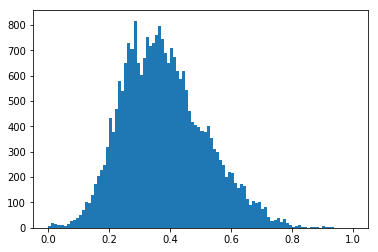

In [1778]:
plt.hist(train_df["Time of Last"], bins = 100)
plt.show()

In [1779]:
train_array = train_df.as_matrix()

In [1780]:
##Here is where we perform the gradient descent

def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def error_fxn(w_vect, x_array, y_vect):
    #This function computes the error function, given a weights vector w_vect
    #This allow us to call this function repeatedly as we optimize the w_vect through gradient descent
    y0 = np.log(sigmoid(x_array.dot(w_vect))).dot(y_vect)
    y1 = np.log(1 - sigmoid(x_array.dot(w_vect))).dot(1-y_vect)
    return -(y0 + y1) / len(y_vect)

def grad_fxn(w_vect, x_array, y_vect): 
    #This function computes the gradient function, given the weights vector w_vect
    return (y_vect - sigmoid(np.dot(x_array, w_vect))).dot(x_array)

def grad_descent(w_vect, x_array, y_vect, step, tol, maxi, print_out = True):
    start = time.time()
    #performs the gradient descent
    grad_history = [[w_vect, error_fxn(w_vect, x_array, y_vect)]]
    #store all the past values of the w vector and the error function
    #(we use this to plot the gradient descent or diagnose problems)
    delta = grad_history[0][1]
    delta = 1
    i = 0
    while(delta > tol): 
        #We continue the descent until the change in error (delta) is less than our tolerance parameter (tol)
        w_old = w_vect
        w_vect = w_old + step * grad_fxn(w_old, x_array, y_vect)
        grad_history.append([w_vect, error_fxn(w_vect, x_array, y_vect)])
        delta =  grad_history[-2][1] - grad_history[-1][1]
        #step = step * 0.8
        #we decrease the step each time to help with convergence
        i = i + 1
        if(i > maxi):
            #We want to end the loop if it has run for two long without converging
            break
    if(print_out):
        print("Exit delta = " + str(delta))
        print("Loops run = " + str(i))
        print("Time = " + str(time.time() - start))
    return w_vect, grad_history

In [1815]:
my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = 1e-4, tol = 1e-6, maxi = 10000)
error_fxn(my_w, train_array, y_vect)

Exit delta = 9.99441790203e-07
Loops run = 633
Time = 1.356900930404663


0.098163839716012474

In [1816]:
my_w

array([ 0.20095175,  2.73993132,  1.77729898,  0.92556287,  0.42760462,
        0.39811266,  0.24229149,  0.32780321,  0.14867243,  0.07843675,
        0.19617011, -0.28942176, -0.13958081, -1.18043561, -0.45239383,
       -4.62903651])

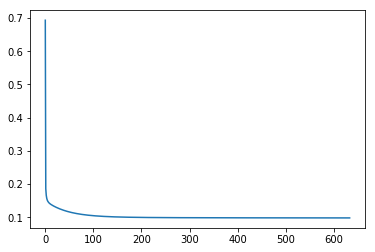

In [1817]:
errs = [i[1] for i in grad_history]
plt.plot(errs)
plt.show()

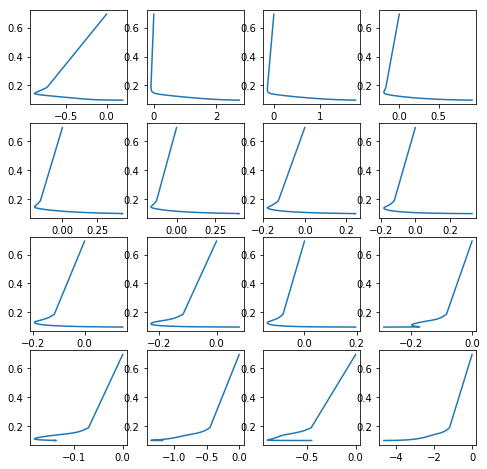

In [1818]:
#plot the gradient descent
#We are plotting the cost function (y-axis) of each iteration
#against the value of one position of the w-vector for that iteration

errs = [i[1] for i in grad_history]
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize = (8,8))
j = 0
for ax in axes.reshape(-1): 
    ax.plot([i[0][j] for i in grad_history], errs)
    j = j+1

In [1785]:
my_w

array([ 0.20095175,  2.73993132,  1.77729898,  0.92556287,  0.42760462,
        0.39811266,  0.24229149,  0.32780321,  0.14867243,  0.07843675,
        0.19617011, -0.28942176, -0.13958081, -1.18043561, -0.45239383,
       -4.62903651])

In [1786]:
train_df.head(2)

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,
4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0.270143,0.357143,1.0
5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,0.566338,0.428571,1.0


# Check the in-sample accuracy of the model 

In [1787]:
def predict_y(w_vect, x_array): 
    prob_y1 = sigmoid(x_array.dot(w_vect))
    #probability
    part_y = np.where(prob_y1 > 0.5, 1, 0)
    #participation
    return part_y

def ratio_predicted(y_pred, y_vect): 
    return sum(np.invert(np.logical_xor(y_vect, y_pred))) / len(y_vect)

Predicted Y=1: 174
Correct predictions for Y=1: 102
Ratio of correct predictions: 0.971823160568
Naive in-sample = 0.970632589888


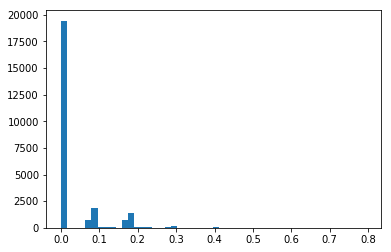

In [1819]:
y_pred = predict_y(my_w, train_array)

print("Predicted Y=1: " + str(sum(y_pred)))
print("Correct predictions for Y=1: " + str(sum(y_pred * y_vect)))
pred_ratio = ratio_predicted(y_pred, y_vect)
print("Ratio of correct predictions: " + str(pred_ratio))
print("Naive in-sample = " + str((1 - sum(y_vect)/ len(y_vect))))
plt.hist(prob_y_pred, bins = 50)
plt.show()

In [1789]:
k_y_train

array([0, 0, 0, ..., 1, 0, 0])

In [1790]:
train_array.shape

(25198, 16)

In [1791]:
k_y_train.shape

(20158,)

In [1823]:
#Lets try k-fold cross validation.
#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)


k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
#Train on 80% of the data (~20k rows)
k_train_array= train_df.loc[k_train_index].as_matrix()
not_df = train_df.index.isin(k_train_index)
k_test_df = train_df[~not_df]
k_test_array = k_test_df.as_matrix()
#Test with the remaining 20% (~5k rows)

k_y_train = y_df.loc[k_train_index].as_matrix()
#training y-vector
k_y_test = y_df.loc[k_test_df.index].as_matrix()
#testing y-vector

k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                           y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

k_y_pred_train = predict_y(k_w, k_train_array)

k_insample = ratio_predicted(k_y_pred_train, k_y_train)

print()
print("In Sample = " + str(k_insample))
print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
print()

#Now, let's look at the out of sample! 

k_y_pred_test = predict_y(k_w, k_test_array)
k_oos = ratio_predicted(k_y_pred_test, k_y_test)

print("Out of Sample = " + str(k_oos))
print("Naive Out of Sample = " + str((1 - sum(k_y_test)/ len(k_y_test))))

Exit delta = 9.9875919149e-07
Loops run = 693
Time = 1.1312270164489746

In Sample = 0.971376128584
Naive in sample = 0.970483182855

Out of Sample = 0.973015873016
Naive Out of Sample = 0.97123015873


In [1837]:
#Lets try k-fold cross validation.

#TODO: prevent the different folds from overlapping
#This is actually bootstrapping rather than k-fold 

#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)

def kfold(k):
    start = time.time()
    accuracy = []
    
    for i in range(1,k):
        k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
        #Train on 80% of the data (~20k rows)
        k_train_array= train_df.loc[k_train_index].as_matrix()
        not_df = train_df.index.isin(k_train_index)
        k_test_df = train_df[~not_df]
        k_test_array = k_test_df.as_matrix()
        #Test with the remaining 20% (~5k rows)

        k_y_train = y_df.loc[k_train_index].as_matrix()
        #training y-vector
        k_y_test = y_df.loc[k_test_df.index].as_matrix()
        #testing y-vector

        k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                                   y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

        k_y_pred_train = predict_y(k_w, k_train_array)

        k_insample = ratio_predicted(k_y_pred_train, k_y_train)

    #     print()
    #     print("In Sample = " + str(k_insample))
    #     print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
    #     print()

        #Now, let's look at the out of sample! 

        k_y_pred_test = predict_y(k_w, k_test_array)
        k_oos = ratio_predicted(k_y_pred_test, k_y_test)
        k_oos_naive = (1 - sum(k_y_test)/ len(k_y_test))
        accuracy.append((k_oos / k_oos_naive))

    #     print("Out of Sample = " + str(k_oos))
    #     print("Naive Out of Sample = " + str(k_oos_naive)
    print("Time Taken = " + str(time.time() - start))
    print("Average Accuracy Above Naive = " + str(np.mean(accuracy)))

In [1838]:
kfold(50)

Time Taken = 59.96378183364868
Average Accuracy Above Naive = 1.00102283231


In [1824]:
sum(k_y_pred)

137

In [1825]:
sum(k_y_train)

595

In [1795]:
# true_y0 = len(y_vect) - sum(y_vect)
# pred_y1 = sum(y_pred)
# pred_y1_correct = sum(y_pred * y_vect)
# pred_y1_wrong = sum(y_pred) - sum(y_pred * y_vect)
# pred_y0_correct = (len(y_vect) - sum(y_vect)) - pred_y1_wrong

# pred_correct = pred_y1_correct + pred_y0_correct
# pred_ratio = pred_correct / len(y_vect)

In [1796]:
1 - sum(y_vect) / len(y_vect)
#This is the true proportion of y=0, which is the naive accuracy

0.97063258988808632

In [1797]:
len(marathon_data[marathon_data["Year"] == 2016])

3016

In [1798]:
len(marathon_data)

35022

In [1799]:
len(train_df[train_df["Lag_1"] == 1])

2730

In [1800]:
len(train_df)

25198

In [1801]:
train_df

,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Time of Last,Age Last,Dummy
Id,,,,,,,,,,,,,,,,
4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0.270143,0.357143,1.0
5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,0.566338,0.428571,1.0
7,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0.301746,0.428571,1.0
9,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0.343062,0.510204,1.0
11,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0.525112,0.408163,1.0
15,1.0,1,0,1,1,0,0,1,0,0,0,0,0,0.524575,0.408163,1.0
16,1.0,1,0,1,1,1,1,0,0,0,0,0,0,0.312131,0.459184,1.0
18,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0.289749,0.510204,1.0
22,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0.335363,0.448980,1.0
